<a href="https://colab.research.google.com/github/tkhro1024/competition/blob/main/kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ◼︎ [kaggle.titanic](https://www.kaggle.com/c/titanic/code)


---


1. Read data from kaggle API 
2. Feature Eng. - Modifying dtype
3. Overview Data
4. Feature Eng. - Add & Delete
5. Choose Model - [Pycaret](https://qiita.com/kotai2003/items/a377f45ddee9829ed2c5) or not
6. Tuning HyperParameter - Optuna or not (GridSearch)
7. Cross Validation
8. Reputation 1st
9. Ensemble learning - tree & NN (Pytorch)
10. Reputation N

##0.Setup

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 54.9MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.26MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 25.2MB/s]


In [ ]:
!ls ../icontent/titanic

ls: cannot access '../icontent/titanic': No such file or directory


In [ ]:
# import library
import os
import pandas as pd 
import pandas_profiling

import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 
import csv
import glob

%matplotlib inline

## 1.Read Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv('/content/gender_submission.csv')

## 2.Feature Eng. - Modifying dtype



### 1. Pclass


### 2. Sex

In [ ]:
data = pd.concat([train, test], sort=False)
# 全体でラベルを張り替えるので、trainとtestを一旦くっつけて、一気に書き換えるのが正解。
data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
# inplace(bool値) : (省略可能) 初期値False | Trueの時、変更を元のデータに反映させます。

### 3. Embarked

In [ ]:
data['Embarked'].fillna(('S'), inplace=True)
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

### 4. Fare

In [ ]:
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

### 5. Age

In [ ]:
data['Age'].fillna(data['Age'].median(), inplace=True)

## 3.Overview Data


In [ ]:
!pip install -U pandas-profiling
train.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Age と目的変数との関係

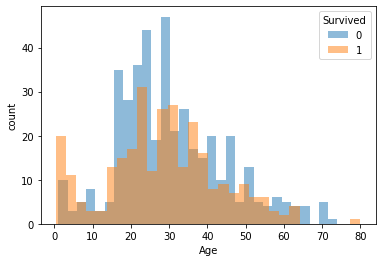

In [ ]:
plt.hist(train.loc[train['Survived'] == 0, 'Age'].dropna(), bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Age'].dropna(), bins=30, alpha=0.5, label='1')
plt.xlabel('Age')
plt.ylabel('count')
plt.legend(title='Survived')
plt.show()

### SibSp と目的変数との関係

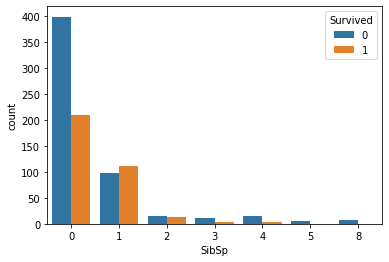

In [ ]:
sns.countplot(x='SibSp', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

### Parchと目的変数との関係

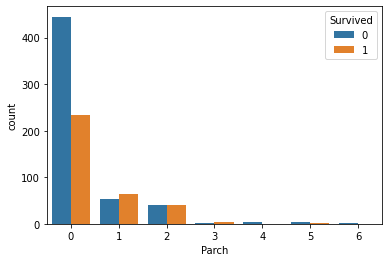

In [ ]:
sns.countplot(x='Parch', hue='Survived', data=train)
plt.legend(loc='upper right', title='Survived')
plt.show()

### Fareと目的変数との関係


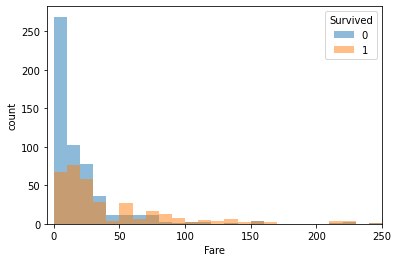

In [ ]:
plt.hist(train.loc[train['Survived'] == 0, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='0')
plt.hist(train.loc[train['Survived'] == 1, 'Fare'].dropna(),
         range=(0, 250), bins=25, alpha=0.5, label='1')
plt.xlabel('Fare')
plt.ylabel('count')
plt.legend(title='Survived')
plt.xlim(-5, 250)
plt.show()

### Pclassのクラスと目的変数との関係


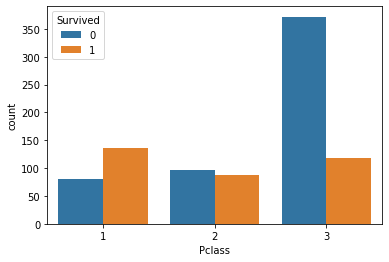

In [ ]:
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.show()

### Sexと目的変数との関係

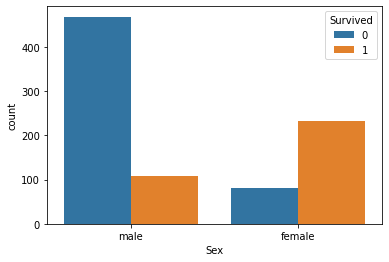

In [ ]:
sns.countplot(x='Sex', hue='Survived', data=train)
plt.show()

### Embarkedと目的変数との関係

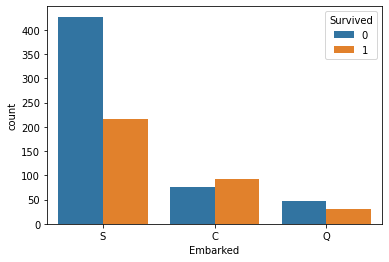

In [ ]:
sns.countplot(x='Embarked', hue='Survived', data=train)
plt.show()

## 4.Feature eng. - Add & Delete



### 6. FamilySize


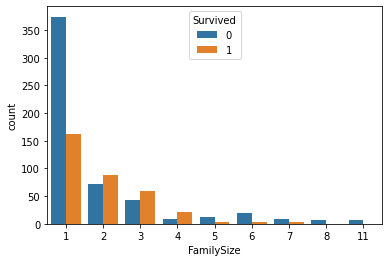

In [ ]:
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data = train, hue='Survived')

### 7. IsAlone


In [ ]:
data['IsAlone'] = 0
data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

train['IsAlone'] = data['IsAlone'][:len(train)]
test['IsAlone'] = data['IsAlone'][len(train):]

In [ ]:
delete_columns = ['Name', 'PassengerId', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True)

train = data[:len(train)]
test = data[len(train):]

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)
X_test = test.drop('Survived', axis=1)

In [ ]:
X_train.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  IsAlone
0       3    0  22.0      1      0   7.2500         0           2        0
1       1    1  38.0      1      0  71.2833         1           2        0
2       3    1  26.0      0      0   7.9250         0           1        1
3       1    1  35.0      1      0  53.1000         0           2        0
4       3    0  35.0      0      0   8.0500         0           1        1

In [ ]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

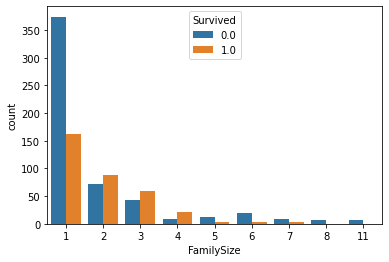

In [ ]:
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
train['FamilySize'] = data['FamilySize'][:len(train)]
test['FamilySize'] = data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', data = train, hue='Survived')

## 5.Choose Model

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *
# from pycaret.regression import *
exp_titanic = setup(data = train, target = 'Survived')

IntProgress(value=0, description='Processing: ', max=3)

Initiated  . . . . . . . . . . . . . . . . . .            07:49:56
Status     . . . . . . . . . . . . . . . . . .  Preprocessing Data

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

Data Type
Pclass      Categorical
Sex         Categorical
Age             Numeric
SibSp       Categorical
Parch       Categorical
Fare            Numeric
Embarked    Categorical
FamilySize  Categorical
IsAlone     Categorical
Survived          Label

In [ ]:
models()

Name  ...  Turbo
ID                                         ...       
lr                    Logistic Regression  ...   True
knn                K Neighbors Classifier  ...   True
nb                            Naive Bayes  ...   True
dt               Decision Tree Classifier  ...   True
svm                   SVM - Linear Kernel  ...   True
rbfsvm                SVM - Radial Kernel  ...  False
gpc           Gaussian Process Classifier  ...  False
mlp                        MLP Classifier  ...  False
ridge                    Ridge Classifier  ...   True
rf               Random Forest Classifier  ...   True
qda       Quadratic Discriminant Analysis  ...   True
ada                  Ada Boost Classifier  ...   True
gbc          Gradient Boosting Classifier  ...   True
lda          Linear Discriminant Analysis  ...   True
et                 Extra Trees Classifier  ...   True
lightgbm  Light Gradient Boosting Machine  ...   True

[16 rows x 3 columns]

In [ ]:
compare_models()
# models()で使用可能ライブラリを見ることができる。

Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.8268  0.8641  0.7328  0.8062   
lightgbm  Light Gradient Boosting Machine    0.8253  0.8699  0.7286  0.8135   
lr                    Logistic Regression    0.8203  0.8628  0.7076  0.8095   
lda          Linear Discriminant Analysis    0.8172  0.8657  0.6991  0.8139   
ridge                    Ridge Classifier    0.8156  0.0000  0.6949  0.8132   
ada                  Ada Boost Classifier    0.8092  0.8486  0.7413  0.7634   
rf               Random Forest Classifier    0.7963  0.8583  0.7241  0.7469   
et                 Extra Trees Classifier    0.7739  0.8382  0.7116  0.7102   
dt               Decision Tree Classifier    0.7675  0.7643  0.7284  0.6959   
knn                K Neighbors Classifier    0.7190  0.7675  0.5947  0.6474   
svm                   SVM - Linear Kernel    0.7061  0.0000  0.6790  0.6477   
qda       Quadratic Discriminant Analysis    0.5025  0.5633  0.8208  0.4387   
nb                            Naive Bayes    0.4237  0.7848  0.9708  0.3975   

              F1   Kappa     MCC  TT (Sec)  
gbc       0.7638  0.6282  0.6338     0.048  
lightgbm  0.7613  0.6251  0.6341     0.020  
lr        0.7507  0.6119  0.6193     0.056  
lda       0.7468  0.6055  0.6147     0.008  
ridge     0.7436  0.6016  0.6113     0.007  
ada       0.7482  0.5953  0.5998     0.047  
rf        0.7322  0.5686  0.5717     0.278  
et        0.7083  0.5245  0.5268     0.264  
dt        0.7074  0.5160  0.5204     0.008  
knn       0.6179  0.3969  0.3995     0.069  
svm       0.6329  0.3975  0.4241     0.008  
qda       0.5594  0.1162  0.1455     0.008  
nb        0.5639  0.0427  0.1037     0.008

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4015, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#XGboost
XGboost = create_model("gbc")  
tuned_XGboost = tune_model(gbc)

# Logistic Regression
LogisticRegression = create_model("lr")  
tuned_LogisticRegression = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7460  0.7799  0.6250  0.6818  0.6522  0.4528  0.4538
1       0.8254  0.8707  0.7083  0.8095  0.7556  0.6207  0.6240
2       0.8254  0.8312  0.7500  0.7826  0.7660  0.6268  0.6272
3       0.7903  0.9019  0.8261  0.6786  0.7451  0.5699  0.5779
4       0.8548  0.8673  0.7500  0.8571  0.8000  0.6869  0.6906
5       0.8548  0.8953  0.7917  0.8261  0.8085  0.6917  0.6921
6       0.8387  0.9068  0.7083  0.8500  0.7727  0.6493  0.6558
7       0.8065  0.8377  0.5833  0.8750  0.7000  0.5654  0.5908
8       0.7903  0.8268  0.6250  0.7895  0.6977  0.5405  0.5491
9       0.8710  0.9101  0.7083  0.9444  0.8095  0.7149  0.7319
Mean    0.8203  0.8628  0.7076  0.8095  0.7507  0.6119  0.6193
SD      0.0358  0.0408  0.0733  0.0783  0.0501  0.0766  0.0770

TypeError: ignored

In [ ]:
# lightGBM
lightGBM = create_model("lightgbm")  
tuned_lightGBM = tune_model("lightgbm")

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7302  0.7874  0.7083  0.6296  0.6667  0.4413  0.4435
1       0.8095  0.9054  0.7917  0.7308  0.7600  0.6025  0.6039
2       0.7460  0.8130  0.6250  0.6818  0.6522  0.4528  0.4538
3       0.8387  0.9175  0.8696  0.7407  0.8000  0.6663  0.6723
4       0.8871  0.9189  0.7917  0.9048  0.8444  0.7565  0.7606
5       0.9032  0.9501  0.8333  0.9091  0.8696  0.7929  0.7948
6       0.8548  0.8728  0.6667  0.9412  0.7805  0.6767  0.6992
7       0.8065  0.8180  0.5417  0.9286  0.6842  0.5582  0.6004
8       0.8387  0.8158  0.7083  0.8500  0.7727  0.6493  0.6558
9       0.8387  0.9002  0.7500  0.8182  0.7826  0.6548  0.6564
Mean    0.8253  0.8699  0.7286  0.8135  0.7613  0.6251  0.6341
SD      0.0522  0.0538  0.0947  0.1057  0.0692  0.1094  0.1093

TypeError: ignored

In [ ]:
plot_model(tuned_XGBoost, plot="feature") 

NameError: ignored

In [ ]:
evaluate_model(tuned_gbc)
# 以下のように個別に求めることも可能である。
# plot_model(dt, plot = 'auc')
# plot_model(dt, plot = 'confusion_matrix')

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
model1 = create_model("lightgbm")
model2 = create_model("rf")
model3 = create_model("gbc")

blender = blend_models([model1, model2, model3])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6984  0.7821  0.6250  0.6000  0.6122  0.3657  0.3659
1       0.8095  0.9081  0.7917  0.7308  0.7600  0.6025  0.6039
2       0.8095  0.8291  0.7083  0.7727  0.7391  0.5896  0.5910
3       0.7903  0.9220  0.8261  0.6786  0.7451  0.5699  0.5779
4       0.8871  0.9134  0.7500  0.9474  0.8372  0.7526  0.7646
5       0.9032  0.9545  0.8750  0.8750  0.8750  0.7961  0.7961
6       0.8871  0.8816  0.7500  0.9474  0.8372  0.7526  0.7646
7       0.8065  0.8136  0.5833  0.8750  0.7000  0.5654  0.5908
8       0.8065  0.8377  0.7083  0.7727  0.7391  0.5857  0.5871
9       0.8065  0.9123  0.7083  0.7727  0.7391  0.5857  0.5871
Mean    0.8205  0.8754  0.7326  0.7972  0.7584  0.6166  0.6229
SD      0.0569  0.0533  0.0829  0.1079  0.0722  0.1182  0.1197

In [ ]:
tuned_blender = tune_model(blender)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7143  0.7831  0.6667  0.6154  0.6400  0.4038  0.4047
1       0.8413  0.9135  0.7917  0.7917  0.7917  0.6635  0.6635
2       0.7937  0.8301  0.6667  0.7619  0.7111  0.5517  0.5547
3       0.8226  0.9264  0.8696  0.7143  0.7843  0.6361  0.6450
4       0.8871  0.9189  0.7500  0.9474  0.8372  0.7526  0.7646
5       0.9032  0.9534  0.8333  0.9091  0.8696  0.7929  0.7948
6       0.8871  0.8805  0.7083  1.0000  0.8293  0.7486  0.7734
7       0.8226  0.8235  0.5833  0.9333  0.7179  0.5984  0.6335
8       0.8387  0.8268  0.7083  0.8500  0.7727  0.6493  0.6558
9       0.8226  0.9057  0.7083  0.8095  0.7556  0.6173  0.6207
Mean    0.8333  0.8762  0.7286  0.8333  0.7709  0.6414  0.6511
SD      0.0518  0.0535  0.0808  0.1122  0.0647  0.1069  0.1095

In [ ]:
final_gbc = finalize_model(tuned_gbc)
data_unseen = pd.read_csv('test.csv')
result = predict_model(final_gbc)

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Gradient Boosting Classifier    0.8657  0.9269  ...  0.8235  0.7151  0.7152

[1 rows x 8 columns]

In [ ]:
test_pred = predict_model(final_gbc, data=test)  # 予測
test_pred

Survived  Pclass  Sex   Age  ...  FamilySize  IsAlone  Label   Score
0         NaN       3    0  34.5  ...           1        1    0.0  0.8750
1         NaN       3    1  47.0  ...           2        0    0.0  0.8662
2         NaN       2    0  62.0  ...           1        1    0.0  0.9270
3         NaN       3    0  27.0  ...           1        1    0.0  0.8784
4         NaN       3    1  22.0  ...           3        0    0.0  0.7005
..        ...     ...  ...   ...  ...         ...      ...    ...     ...
413       NaN       3    0  28.0  ...           1        1    0.0  0.8695
414       NaN       1    1  39.0  ...           1        1    1.0  0.9673
415       NaN       3    0  38.5  ...           1        1    0.0  0.9263
416       NaN       3    0  28.0  ...           1        1    0.0  0.8695
417       NaN       3    0  28.0  ...           3        0    0.0  0.5782

[418 rows x 12 columns]

In [ ]:
# 形式を整える
subm_data = test_pred[["PassengerId", "Label"]]  # 列を抜き出す
subm_data = subm_data.rename(columns={"Label" : "Survived"})  # 列名の変更

# 提出用のcsvファイルを保存
subm_data.to_csv("submission_titanic.csv", index=False)

subm_data

KeyError: ignored